In [14]:
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import product
from scipy.stats import ttest_ind, pearsonr
from sklearn.metrics import confusion_matrix as cm, roc_curve, roc_auc_score

In [15]:
# set cwd and paths
cwd = "/home/marnec/Projects/CAID/caid/"
results_d = cwd + "results/"
baseline_d = cwd + "baseline/"

In [16]:
# set reference pool; nan rule
refpool = "new-disprot-all"
nanrule = "simple"
ref = "_".join([refpool, nanrule])

In [17]:
# set ouptut type; predictor; scope; threshold optimization; result type
outtype = "analysis"
pred = "all"
scope = "dataset"
threshold = "default"

In [18]:
# set result type {metrics, pr, roc, cmat, predictions}; extension
restype = "metrics"
extension = "csv"

In [19]:
# build result file name
metrics_f = results_d + ".".join([ref, outtype, pred, scope, threshold, restype, extension])

def load_metrics(results_d, ref, scope, threshold, restype):
    idx_col = 0 if scope == "dataset" else [0, 1]
    df = pd.read_csv(results_d + ".".join([ref, "analysis", "all", scope, threshold, restype, "csv"]), index_col=idx_col)
    return df

In [20]:
def load_baseline(baseline_d, ref, basetype, scope, threshold, restype):
    if basetype in {"random", "shuffletargets", "shuffledataset"}:
        df = pd.read_csv(baseline_d + ".".join([ref, basetype, "avg", scope, threshold, restype,"csv"]), index_col=0)
        # select only mean row
        df = df.loc["mean"].to_frame(basetype).T
    else:
        df = pd.read_csv(baseline_d + ".".join([ref, basetype, "all", scope, threshold, restype,"csv"]), index_col=0)
    return df

def merge_baselines(random, shfdat, shftgt, cons, *naive):
    return pd.concat([random, shfdat, shftgt, cons, *naive])

In [21]:
# load dataset metrics
dat_pred_metrics = load_metrics(results_d, ref, scope, threshold, restype)
dat_base_metrics = merge_baselines(
    load_baseline(baseline_d, ref, "random", scope, threshold, "metrics"),                         # baseline random
    load_baseline(baseline_d, ref, "shuffledataset", scope, threshold, "metrics"),                 # baseline shuffle dataset
    load_baseline(baseline_d, ref, "shuffletargets", scope, threshold, "metrics"),                 # baseline shuffle target
    load_baseline(baseline_d, ref, "cons", scope, threshold, "metrics"),                           # baseline cons
    load_baseline(baseline_d, ref, "naive-new-pdb-r_simple", scope, threshold, "metrics"))         # baseline naive

IMPORTANT:
* dataset: new-disprot_all_simple:
    * new: last round annotations
    * disprot: disorder comes from disprot annotations
    * all: no filtering by method (xray, nmr...)
    * simple: residues falling out of disprot annotaions are considered ordered
* threshold: default 
* baselines:
    * random: completely random
    * suffledataset: random shuffling at dataset level (disorder content maintaned at dataset level)
    * shuffletarget: random shuffling at protein level (disorder content maintaned at protein level)
    * new-disprot-all_simple_cons: naive predictor based on the opposite of conservation
    * new-disprot-pdb-r_simple: what is not on pdb is disorder

## Metrics tables

* bac: balanced accuracy,
* csi: critical score index / threat score,
* f05: f 0.5 score
* f1s: f 1 score / f score,
* f2s: f 2 score
* fnr: false negative rate / miss-rate
* fom: false omission rate
* fpr: false postive rate / fall-out
* inf: informedness / bookmaker informedness 
* mcc: matthew's correlation coefficient
* mk: markedness
* npv: negative predictive value
* ppv: precision / positive predictive value
* tnr: true negative rate / specificity / selectivity 
* tpr: true positive rate / sensitivity / recall
* aucroc: area under the ROC curve
* aucpr aurea under the Precision-Recall curve
* aps: average precision score
* thr: prediction score cutoff

### Metrics calculated at dataset level

In [22]:
dat_pred_metrics.append(dat_base_metrics).sort_values('mcc', ascending=False)


,bac,csi,f05,f1s,f2s,fnr,fom,fpr,inf,mcc,mk,npv,ppv,tnr,tpr,aucroc,aucpr,aps,thr
D029_SPOT-Disorder2,0.720,0.306,0.381,0.469,0.608,0.241,0.071,0.320,0.439,0.343,0.268,0.929,0.339,0.680,0.759,0.760,0.340,0.340,0.370
D013_fIDPln,0.679,0.287,0.417,0.446,0.480,0.494,0.101,0.147,0.359,0.327,0.298,0.899,0.399,0.853,0.506,0.793,0.422,0.421,0.353
D014_fIDPnn,0.626,0.241,0.470,0.388,0.330,0.700,0.124,0.048,0.252,0.327,0.424,0.876,0.548,0.952,0.300,0.814,0.475,0.475,0.505
D025_RawMSA,0.709,0.285,0.365,0.444,0.567,0.304,0.075,0.279,0.417,0.323,0.251,0.925,0.326,0.721,0.696,0.779,0.386,0.385,0.500
D028_SPOT-Disorder1,0.707,0.274,0.343,0.430,0.577,0.252,0.068,0.334,0.414,0.311,0.234,0.932,0.302,0.666,0.748,0.744,0.268,0.268,0.460
D026_AUCpreD,0.696,0.276,0.354,0.433,0.556,0.313,0.081,0.296,0.391,0.303,0.235,0.919,0.316,0.704,0.687,0.757,0.479,0.312,0.500
D002_Predisorder,0.695,0.264,0.324,0.418,0.588,0.193,0.063,0.417,0.390,0.292,0.219,0.937,0.282,0.583,0.807,0.747,0.325,0.324,0.500
D018_ESpritz-D,0.632,0.242,0.417,0.390,0.366,0.648,0.121,0.088,0.264,0.289,0.316,0.879,0.437,0.912,0.352,0.774,0.410,0.409,0.508
D008_IsUnstruct,0.692,0.260,0.325,0.413,0.565,0.252,0.071,0.363,0.385,0.287,0.214,0.929,0.285,0.637,0.748,0.744,0.323,0.314,0.500
D005_IUPred-long,0.683,0.264,0.345,0.418,0.530,0.355,0.087,0.280,0.365,0.285,0.222,0.913,0.309,0.720,0.645,0.737,0.298,0.298,0.502


In [23]:
# load target metrics
tgt_pred_metrics = load_metrics(results_d, ref, "target", threshold, restype)                         # predictors metrics
bts_pred_metrics = load_metrics(results_d, ref, "bootstrap", threshold, restype)                      # predictors bootstrap
tgt_base_metrics = merge_baselines(
    load_baseline(baseline_d, ref, "random", "target", threshold, "metrics"),                         # baseline random
    load_baseline(baseline_d, ref, "shuffledataset", "target", threshold, "metrics"),                 # baseline shuffle dataset
    load_baseline(baseline_d, ref, "shuffletargets", "target", threshold, "metrics"),                 # baseline shuffle target
    load_baseline(baseline_d, ref, "cons", "target", threshold, "metrics"),                           # baseline cons
    load_baseline(baseline_d, ref, "naive-new-pdb-r_simple", "target", threshold, "metrics"))  # baseline naive

###  Metrics calculated at target level

In [24]:
# performance averaged over targets
tgt_pred_metrics.groupby(level=0).mean().append(tgt_base_metrics.groupby(level=0).mean()).sort_values("mcc", ascending=False).round(3)

,bac,csi,f05,f1s,f2s,fnr,fom,fpr,inf,mcc,mk,npv,ppv,tnr,tpr,thr,aucroc,aucpr,aps
D029_SPOT-Disorder2,0.701,0.385,0.456,0.480,0.544,0.307,0.198,0.301,0.379,0.305,0.259,0.802,0.457,0.699,0.693,0.370,NaN,NaN,NaN
D025_RawMSA,0.697,0.369,0.441,0.459,0.518,0.342,0.180,0.274,0.369,0.300,0.271,0.820,0.450,0.726,0.658,0.500,NaN,NaN,NaN
D028_SPOT-Disorder1,0.681,0.361,0.438,0.453,0.506,0.347,0.196,0.302,0.338,0.282,0.251,0.804,0.448,0.698,0.653,0.460,NaN,NaN,NaN
D026_AUCpreD,0.675,0.349,0.425,0.442,0.497,0.370,0.195,0.283,0.336,0.270,0.238,0.805,0.434,0.717,0.630,0.500,NaN,NaN,NaN
D005_IUPred-long,0.659,0.312,0.401,0.407,0.451,0.426,0.182,0.260,0.298,0.250,0.248,0.818,0.431,0.740,0.574,0.502,NaN,NaN,NaN
shuffletargets,0.624,0.227,0.000,0.000,0.000,1.000,0.122,0.122,-0.122,0.249,0.878,0.878,1.000,0.878,0.000,1.000,0.624,0.421,0.239
D003_IUPred2A-long,0.656,0.308,0.400,0.404,0.445,0.438,0.185,0.253,0.294,0.247,0.247,0.815,0.432,0.747,0.562,0.502,NaN,NaN,NaN
D002_Predisorder,0.688,0.332,0.391,0.440,0.540,0.231,0.169,0.412,0.349,0.247,0.203,0.831,0.372,0.588,0.769,0.500,NaN,NaN,NaN
D011_DISOPRED-3.1,0.644,0.298,0.394,0.390,0.426,0.450,0.198,0.253,0.295,0.245,0.236,0.802,0.434,0.747,0.550,0.500,NaN,NaN,NaN
D004_IUPred2A-short,0.648,0.299,0.401,0.398,0.428,0.485,0.197,0.210,0.295,0.242,0.229,0.803,0.426,0.790,0.515,0.501,NaN,NaN,NaN


In [25]:
def plot_dataset_target_metric(metric):
    fig, axes = plt.subplots(1, 2, figsize=(12, 4), sharey=True)
    
    
    # plot dataset metrics on left subplot
    dat_m = dat_pred_metrics[metric].sort_values(ascending=False).append(
        dat_base_metrics[metric].sort_values(ascending=False))
    
    ax = dat_m.plot.bar(
        ax=axes[0],
        color=['silver']*len(dat_pred_metrics) + ['grey']*len(dat_base_metrics),
        yerr=bts_pred_metrics.xs('bac', level=1)[["lo", 'hi']].reindex(dat_m.index)
    )
    ax.axhline(dat_base_metrics[metric].max())
    
    # plot target metrics on right subplot
    tgt_m = tgt_pred_metrics.groupby(level=0).mean()[metric].sort_values(ascending=False).append(
        tgt_base_metrics.groupby(level=0).mean()[metric].sort_values(ascending=False))
        
    ax = tgt_m.plot.bar(
        ax=axes[1], 
        color=['silver']*len(tgt_pred_metrics.groupby(level=0).mean()) + ['grey']*len(tgt_base_metrics.groupby(level=0).mean()),
        yerr=tgt_pred_metrics.groupby(level=0).std()[metric].append(
            tgt_base_metrics.groupby(level=0).std()[metric])[tgt_m.index] / 2)
    ax.axhline(tgt_base_metrics.groupby(level=0).mean()[metric].max())

## Plot of single metrics at dataset and target levels with errors
### Balanced accuracy
* dataset level (sx); error: confidence interval calculated on 1000-rounds bootstrap (invisible since too small)
* target level (dx); standard deviation

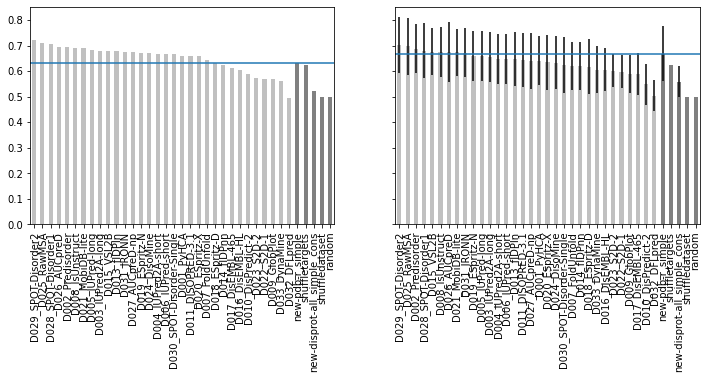

In [26]:
plot_dataset_target_metric("bac")

### F 1 score
* dataset level (sx); error: confidence interval calculated on 1000-rounds bootstrap (invisible since too small)
* target level (dx); standard deviation

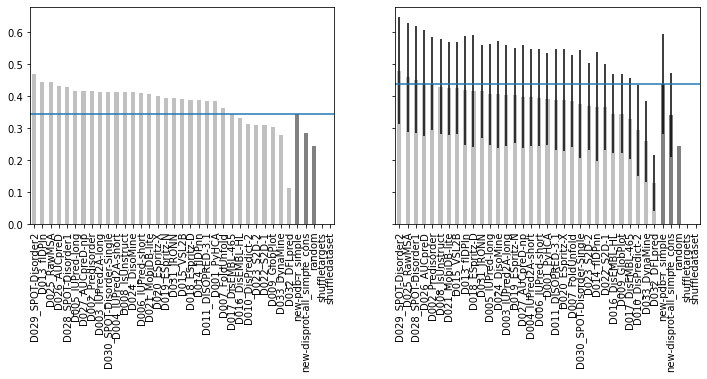

In [27]:
plot_dataset_target_metric("f1s")

### MCC
* dataset level (sx); error: confidence interval calculated on 1000-rounds bootstrap (invisible since too small)
* target level (dx); standard deviation

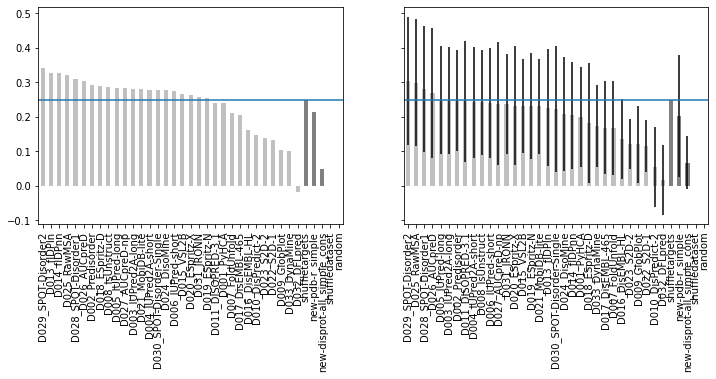

In [28]:
plot_dataset_target_metric("mcc")

## Example of confidence interval
Confidence Interval for the distribution of 1000 Balanced Accuracy (calculated at the dataset level) scores for IUpred2A.

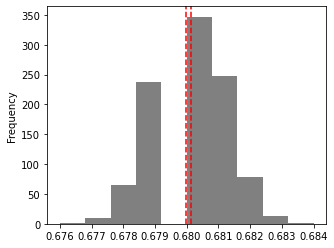

In [29]:
m = "bac"
lo, hi, thr = bts_pred_metrics.loc["D003_IUPred2A-long"].loc[m]
fig, ax = plt.subplots(figsize=[5, 4])
ax = pd.read_csv(
    "/home/marnec/Projects/CAID/caid/results/new-disprot-all_simple.analysis.D003_IUPred2A-long.bootstrap.metrics.csv",
    index_col=[0, 1])[str(thr)].xs(m, level=1).plot.hist(ax=ax, color='grey')
_ = ax.axvline(hi, c='r', linestyle='--')
_ = ax.axvline(lo, c='r', linestyle='--')

## MCC per target per predictor
Heatmap representing the MCC for each target for each predictor. Sorted by average-target MCC (big-->small), which can be seen on upper tick labels.

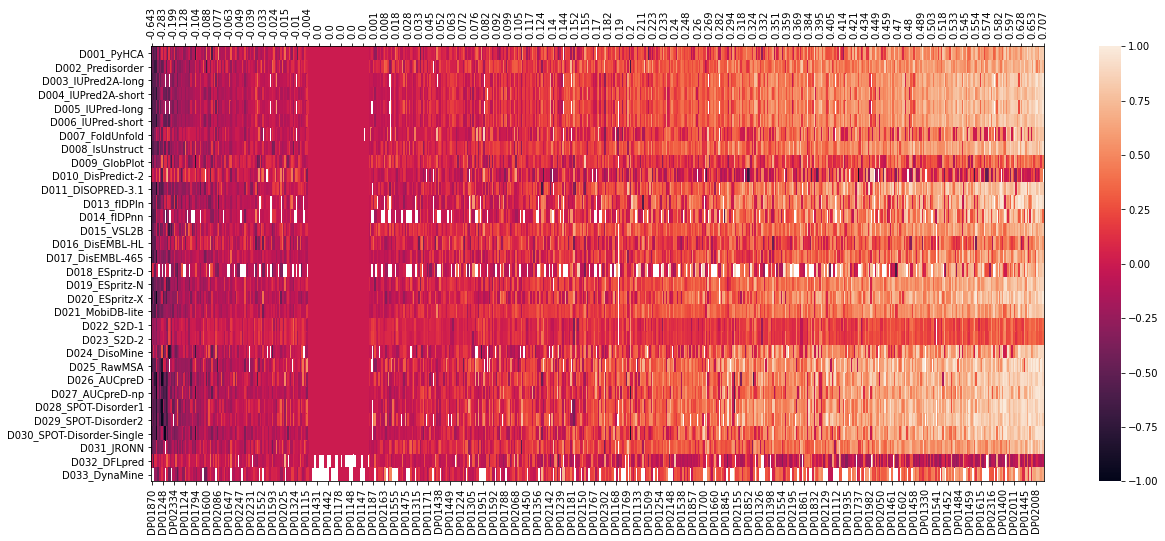

In [30]:
fig , ax = plt.subplots(figsize=(20, 8))
tgt_pred_metrics_avg = tgt_pred_metrics["mcc"].unstack().mean().sort_values()
ax = sns.heatmap(tgt_pred_metrics["mcc"].unstack().reindex(tgt_pred_metrics_avg.index, axis=1), ax=ax)
ax2 = ax.twiny()
ax2.set_xticks(ax.xaxis.get_ticklocs())
ax2.set_xticklabels(tgt_pred_metrics_avg.values[[list(tgt_pred_metrics_avg.index).index(l.get_text()) for l in ax.xaxis.get_ticklabels()]].round(3))
ax2.tick_params(axis='x', rotation=90);

## Predictor correlation
MCC calculated at the target level of all predictors against all predictors. Each point is a target, their coordinates are their MCC calculated from predictor x and predictor y. The Diagonal shows the distribution of MCC for predictor x=y

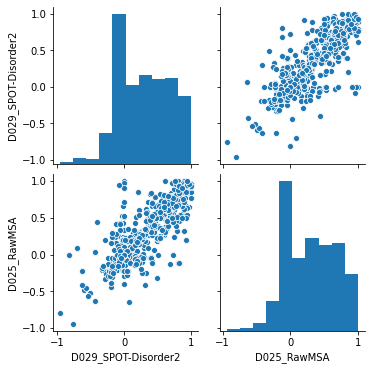

In [52]:
t = tgt_pred_metrics["mcc"].unstack().reindex(tgt_pred_metrics["mcc"].groupby(level=0).mean().sort_values(ascending=False).index)
sns.pairplot(t.head(2).T);
# plt.savefig('test.png')

### ROC curve
ROC curve. x axis 1-specificity; y axis sensitivity. Only first 10 best ranking methods are shown. Ranking is based on ROC AUC.

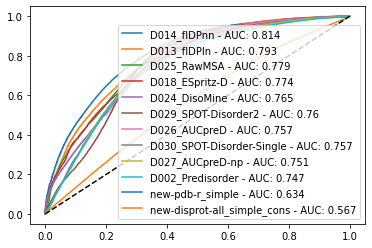

In [32]:
pred_rocs = pd.read_csv("/home/marnec/Projects/CAID/caid/results/new-disprot-all_simple.analysis.all.dataset._.roc.csv", index_col=[0], header=[0,1,2])
naive_roc = pd.read_csv("/home/marnec/Projects/CAID/caid/baseline/new-disprot-all_simple.naive-new-pdb-r_simple.all.dataset._.roc.csv", index_col=[0], header=[0,1,2])
cons_roc = pd.read_csv("/home/marnec/Projects/CAID/caid/baseline/new-disprot-all_simple.cons.all.dataset._.roc.csv", index_col=[0], header=[0,1,2])

# create auc ranking of all predictor + baselines
auc_roc = sorted(pred_rocs.join(naive_roc).join(cons_roc).columns.droplevel(2).unique(), key=lambda t: t[1], reverse=True)
# select first 10 predictors 
rocs = pred_rocs.reindex(list(zip(*auc_roc))[0], axis=1, level=0).T.head(20)
# add baselines if they are not among the best 10
rocs = rocs.append(naive_roc.T) if naive_roc.index.get_level_values(0)[0] not in rocs.index.get_level_values('predictor').unique() else rocs
rocs = rocs.append(cons_roc.T) if cons_roc.index.get_level_values(0)[0] not in rocs.index.get_level_values('predictor').unique() else rocs
# recreate auc ranking with first 10 predictors and baselines
auc_roc = sorted(rocs.index.droplevel(2).unique(), key=lambda t: t[1], reverse=True)
lines = plt.plot(*rocs.reindex(list(zip(*auc_roc))[0], level=0).values)
plt.plot([0, 1], [0, 1], color='k', linestyle='--')
plt.legend(lines, ["{} - AUC: {}".format(*t) for t in auc_roc]);

### Precision-Recall curve
Precision-Recall curve. x axis recall; y axis precision. Only first 10 best ranking methods are shown.
* (sx) Ranking is based on PR AUC
* (dx) Ranking is based on APS (average precision score)

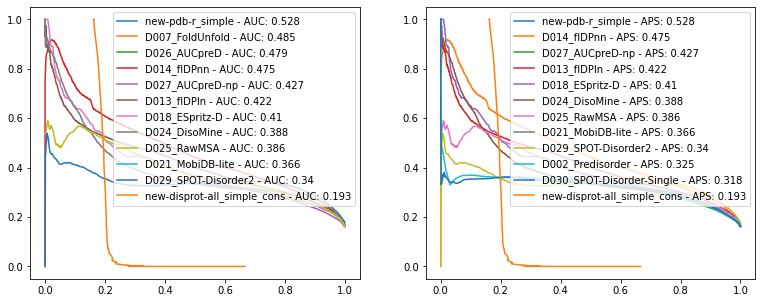

In [33]:
fig, axes = plt.subplots(1,2, figsize=(13, 5))
pred_prcs = pd.read_csv("/home/marnec/Projects/CAID/caid/results/new-disprot-all_simple.analysis.all.dataset._.pr.csv", index_col=[0], header=[0,1,2,3])
naive_prc = pd.read_csv("/home/marnec/Projects/CAID/caid/baseline/new-disprot-all_simple.naive-new-pdb-r_simple.all.dataset._.pr.csv", index_col=[0], header=[0,1,2, 3])
cons_prc = pd.read_csv("/home/marnec/Projects/CAID/caid/baseline/new-disprot-all_simple.cons.all.dataset._.pr.csv", index_col=[0], header=[0,1,2,3])

auc_pr = sorted(pred_prcs.join(naive_prc).join(cons_prc).columns.droplevel([2, 3]).unique(), key=lambda t: t[1], reverse=True)
aps_pr = sorted(pred_prcs.columns.droplevel([1, 3]).unique(), key=lambda t: t[1], reverse=True)

# select first 10 predictors (based on AUC)
prcs = pred_prcs.reindex(list(zip(*auc_pr))[0], axis=1, level=0).T.head(20)
# add baselines if they are not among the best 10
prcs = prcs.append(naive_prc.T) if naive_prc.index.get_level_values(0)[0] not in prcs.index.get_level_values('predictor').unique() else prcs
prcs = prcs.append(cons_prc.T) if cons_prc.index.get_level_values(0)[0] not in prcs.index.get_level_values('predictor').unique() else prcs
# recreate auc ranking with first 10 predictors and baselines
auc_pr = sorted(prcs.index.droplevel([2,3]).unique(), key=lambda t: t[1], reverse=True)
lines = axes[0].plot(*prcs.reindex(list(zip(*auc_pr))[0], level=0).values)
axes[0].legend(lines, ["{} - AUC: {}".format(*t) for t in auc_pr]);


# select first 10 predictors (based on APS)
prcs = pred_prcs.reindex(list(zip(*aps_pr))[0], axis=1, level=0).T.head(20)
# add baselines if they are not among the best 10
prcs = prcs.append(naive_prc.T) if naive_prc.index.get_level_values(0)[0] not in prcs.index.get_level_values('predictor').unique() else prcs
prcs = prcs.append(cons_prc.T) if cons_prc.index.get_level_values(0)[0] not in prcs.index.get_level_values('predictor').unique() else prcs
# recreate auc ranking with first 10 predictors and baselines
aps_pr = sorted(prcs.index.droplevel([2,3]).unique(), key=lambda t: t[1], reverse=True)
lines = axes[1].plot(*prcs.reindex(list(zip(*aps_pr))[0], level=0).values)
axes[1].legend(lines, ["{} - APS: {}".format(*t) for t in aps_pr]);

## Metrics correlation
### Pearson correlation between metrics calculated at the dataset level

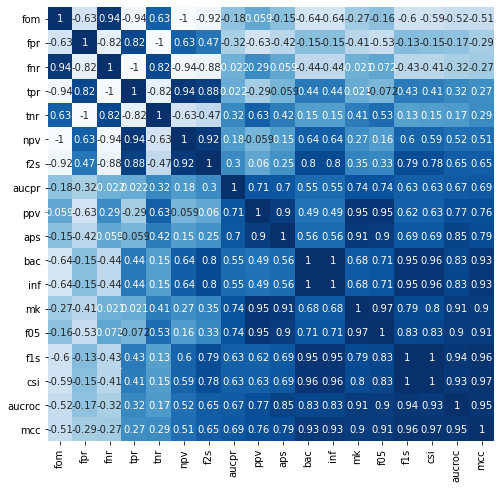

In [34]:
fig, ax = plt.subplots(figsize=(8, 8))
ax = sns.heatmap(dat_pred_metrics.reindex(dat_pred_metrics.corr().mean().sort_values().drop('thr').index, axis=1).corr(), cmap='Blues', cbar=False, annot=True)

### Clustering between metrics calculated at the dataset level
Clustering distance is calculated as correlation 

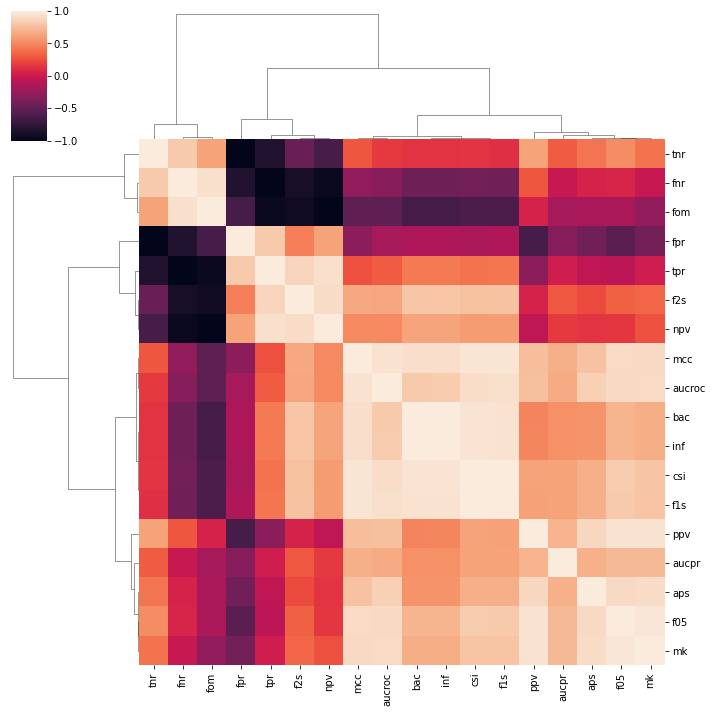

In [35]:
g = sns.clustermap(dat_pred_metrics.drop('thr', axis=1).corr(), metric="correlation")

## Ranking
### Raw ranking of each metric

In [36]:
dat_pred_ranking = dat_pred_metrics.append(dat_base_metrics).rank(axis=0, method='max', ascending=False, na_option='bottom').drop("thr", axis=1)
dat_pred_ranking = dat_pred_ranking.reindex(dat_pred_ranking.mean(axis=1).sort_values().index)
dat_pred_ranking

,bac,csi,f05,f1s,f2s,fnr,fom,fpr,inf,mcc,mk,npv,ppv,tnr,tpr,aucroc,aucpr,aps
D029_SPOT-Disorder2,1.0,1.0,4.0,1.0,1.0,30.0,30.0,18.0,1.0,1.0,6.0,9.0,6.0,21.0,8.0,6.0,12.0,6.0
D025_RawMSA,2.0,3.0,5.0,3.0,5.0,25.0,28.0,21.0,2.0,4.0,7.0,10.0,10.0,17.0,13.0,3.0,10.0,5.0
D013_fIDPln,11.0,2.0,3.0,2.0,25.0,10.0,14.0,33.0,11.0,3.0,5.0,24.0,5.0,5.0,28.0,2.0,6.0,2.0
D026_AUCpreD,4.0,4.0,10.0,4.0,8.0,24.0,26.0,19.0,4.0,6.0,8.0,12.0,14.0,19.0,15.0,8.0,3.0,13.0
D027_AUCpreD-np,13.0,6.0,6.0,8.0,19.0,16.0,19.0,27.0,13.0,11.0,10.0,19.0,8.0,11.0,22.0,9.0,5.0,10.0
D002_Predisorder,5.0,8.0,18.0,8.0,2.0,32.0,34.0,8.0,5.0,7.0,18.0,5.0,20.0,30.0,6.0,10.0,13.0,8.0
D028_SPOT-Disorder1,3.0,5.0,15.0,5.0,3.0,29.0,32.0,15.0,3.0,5.0,9.0,6.0,18.0,23.0,10.0,12.0,28.0,24.0
D014_fIDPnn,25.0,21.0,1.0,21.0,33.0,4.0,7.0,37.0,25.0,3.0,3.0,32.0,3.0,1.0,34.0,1.0,4.0,1.0
D008_IsUnstruct,6.0,13.0,17.0,13.0,7.0,29.0,30.0,12.0,6.0,9.0,19.0,9.0,19.0,26.0,10.0,12.0,14.0,11.0
D024_DisoMine,15.0,13.0,11.0,13.0,20.0,17.0,18.0,25.0,15.0,16.0,14.0,20.0,13.0,13.0,21.0,5.0,9.0,4.0


### Average Overall Ranking
Average Overall ranking of predictors based on multiple metrics. For each metric a ranking is calculated so that each predictor has a distribution of rankings. THe matrix represents the statistical significance (expressed as p-value) of the difference between distribution of rankings. The order of predictors in the matrix reflects the overall ranking (average of the distribution of ranking).

In [37]:
cartesian_product = product(dat_pred_ranking.index, dat_pred_ranking.index)
dat_pred_ranking_pvals = [[*couple, ttest_ind(*dat_pred_ranking.loc[[*couple]].values, equal_var=False)[1]] for couple in cartesian_product]
dat_pred_ranking_pvals = pd.DataFrame(dat_pred_ranking_pvals).set_index([0, 1]).unstack()
dat_pred_ranking_pvals.columns = dat_pred_ranking_pvals.columns.droplevel(0)
dat_pred_ranking_pvals = dat_pred_ranking_pvals.reindex(index=dat_pred_ranking.index, columns=dat_pred_ranking.index).round(3)

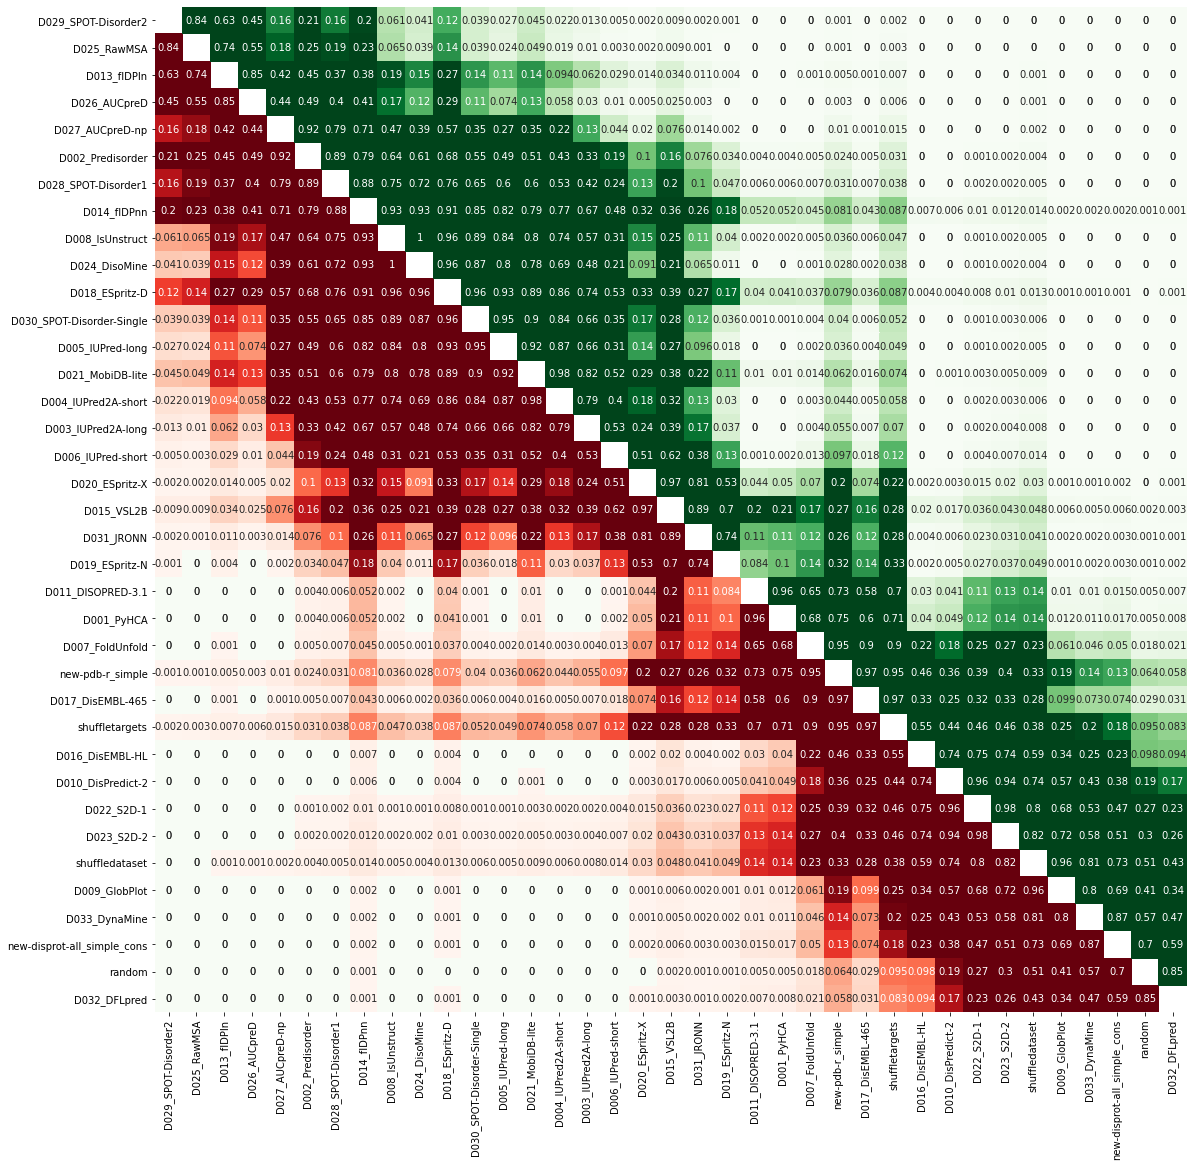

In [38]:
giog, axes = plt.subplots(figsize=(len(dat_pred_ranking_pvals)/2,len(dat_pred_ranking_pvals)/2))
ax = sns.heatmap(dat_pred_ranking_pvals,annot=True, mask=np.triu(dat_pred_ranking_pvals), cmap="Reds", cbar=False, center=0.1, vmax=0.2)
ax = sns.heatmap(dat_pred_ranking_pvals,annot=True, mask=np.tril(dat_pred_ranking_pvals), cmap="Greens", cbar=False, center=0.1, vmax=0.2)

In [39]:
pd.read_csv("../data/disprot7consensus.tsv", sep="\t", index_col=["disprot_id"])["consensus"].apply(lambda r: r.count("D")/len(r)).mean()

0.3541292880258076

In [40]:
predictions = pd.read_csv("/home/marnec/Projects/CAID/caid/results/new-disprot-all_simple.analysis.all.dataset._.predictions.csv", index_col=[0,1], header=[0,1])
baseline_cons = pd.read_csv("/home/marnec/Projects/CAID/caid/baseline/new-disprot-all_simple.cons.all.dataset._.predictions.csv", index_col=[0,1], header=[0,1])
baseline_pdbr = pd.read_csv("/home/marnec/Projects/CAID/caid/baseline/new-disprot-all_simple.naive-new-pdb-r_simple.all.dataset._.predictions.csv", index_col=[0,1], header=[0,1])
baseline_gene3dr = pd.read_csv("/home/marnec/Projects/CAID/caid/baseline/new-disprot-all_simple.naive-new-gene3d-r_simple.all.dataset._.predictions.csv", index_col=[0,1], header=[0,1])
predictions = pd.DataFrame({**predictions.to_dict(), **baseline_cons.to_dict(), **baseline_pdbr.to_dict(), **baseline_gene3dr.to_dict()}).dropna()

In [41]:
idcontent_ref = predictions[("ref", "states")].groupby(level=0).mean()
idcontent_pred = predictions.groupby(level=0).mean()

## Disorder content
Correlation beween disorder content in the reference and predicted disorder content. Each dot is a protein in the dataset. The legend show Pearson R value.

In [50]:
len(predictions.columns.get_level_values(0).unique())

36

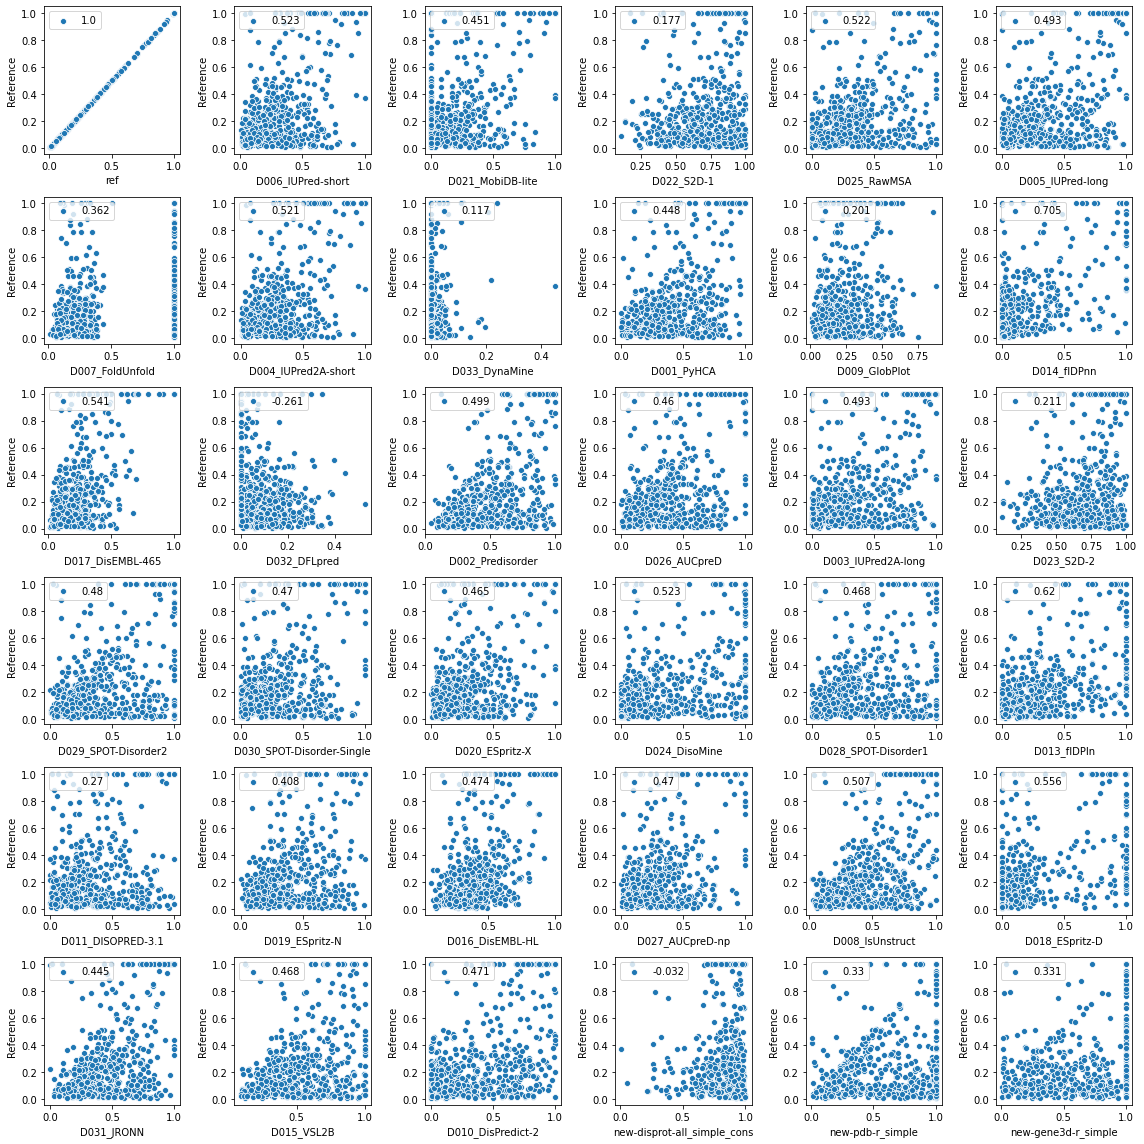

In [29]:
fig, axes = plt.subplots(6, 6, figsize=(16, 16))
axes = axes.flatten()
for ax, p in zip(axes, predictions.columns.get_level_values(0).unique()):
    x = predictions[(p, "states")].groupby(level=0).mean()
    y = idcontent_ref
    sns.scatterplot(x, y, ax=ax, label=round(pearsonr(x, y)[0], 3))
    ax.legend(loc="upper left")
    ax.set_ylabel("Reference")
    ax.set_xlabel(p)

plt.tight_layout()

## Fully disordered 
Performance of predictors on discriminate fully disordered proteins (>95% id content) from non-fully disordered proteins

In [30]:
fullid = (idcontent_pred.xs("states", axis=1, level=1).round(3) > 0.95).astype(int)
fullid_r = fullid["ref"].astype(int)
fullid_p = fullid.astype(int).drop("ref", axis=1)
fullid_cm = fullid.apply(lambda s: cm(fullid_r.values, s.values, labels=[0, 1]).ravel())
fullid_cm.index = ["tn", "fp", "fn", "tp"]
fullid_cm.T.sort_values("fp")

,tn,fp,fn,tp
ref,529,0,0,40
D016_DisEMBL-HL,529,0,36,4
D032_DFLpred,529,0,40,0
D009_GlobPlot,529,0,40,0
D033_DynaMine,529,0,40,0
D017_DisEMBL-465,529,0,38,2
D006_IUPred-short,528,1,30,10
D004_IUPred2A-short,527,2,30,10
D021_MobiDB-lite,527,2,29,11
D019_ESpritz-N,525,4,28,12


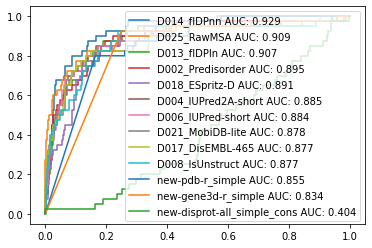

In [138]:
fullidrocs = predictions.xs("scores", level=1, axis=1).groupby(level=0).mean().apply(lambda s: roc_curve(fullid_r, s)[:-1])

fullidaucs = predictions.xs("scores", level=1, axis=1).groupby(level=0).mean().apply(lambda s: roc_auc_score(fullid_r, s))
fullidrocs = fullidrocs.to_frame().assign(auc=fullidaucs).sort_values("auc", ascending=False)

fullidrocs_p = fullidrocs.loc[["new-pdb-r_simple", "new-gene3d-r_simple", "new-disprot-all_simple_cons"]]
fullidrocs = fullidrocs.drop(["new-pdb-r_simple", "new-gene3d-r_simple", "new-disprot-all_simple_cons"])

concatperplot = fullidrocs.head(10).append(fullidrocs_p)[0]
lines = plt.plot(*[item for sublist in concatperplot for item in sublist])
_ = plt.legend(lines, ["{} AUC: {}".format(p, fullidaucs[p].round(3)) for p in concatperplot.index])
